In [1]:
%%writefile load_imgs.py
import cv2
import numpy as np
def load_imgs(file,size=100):
    pic = cv2.imread(file)
    pic = cv2.resize(pic,(size,size))
    flg = file.split(r"\\")[-1] 
    if flg.startswith("cat"):
        label = 0
    else:
        label = 1
    
    return [pic,label]
def process_frame(f, size=100):
    return f, load_imgs(f[0],f[1])

Overwriting load_imgs.py


In [2]:
import numpy as np
import pandas as pd

from multiprocessing import Pool
from load_imgs import process_frame
from tqdm import tqdm
import cv2
import PIL
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, classification_report




randomSeed = 36

Loading the data

In [3]:
picSize = 64
img_to_load = [(r"data\dogs-vs-cats\train\\"+i,picSize) for i in listdir(r"data\dogs-vs-cats\train\\")]
###########
random.shuffle(img_to_load)
img_to_load = img_to_load
############
p = Pool(processes=4)
func_input = [[i,picSize]  for i in img_to_load]
out = p.starmap(process_frame,func_input)


In [4]:
data = [out[i][1][0] for i in range(len(out))]
target = [out[i][1][1] for i in range(len(out))]
out=None

Image transformations with pipelines


In [5]:
def erode_img(Data,matrix=None, iterations=0):
    newData = []
    if iterations > 0:
        for i in range(len(Data)):
            newData.append(cv2.erode(Data[i],matrix,iterations=iterations))
        return newData
    return Data 

In [6]:
def blur_img(Data,matrix=None,sigmaX=0):
    newData = []
    if sigmaX > 0:
        for i in range(len(Data)):
            newData.append(cv2.GaussianBlur(Data[i],matrix,sigmaX))
        return newData
    return Data 

In [7]:
def dilate_img(Data,matrix=None, iterations=0):
    newData = []
    if iterations > 0:
        for i in range(len(Data)):
            newData.append(cv2.dilate(Data[i],matrix,iterations=iterations))
        return newData
    return Data

In [8]:
def grayScale_img(Data):
    newData = []
    for i in range(len(Data)):
        newData.append(cv2.cvtColor(Data[i], cv2.COLOR_BGR2GRAY))
    return newData

move data to data frame

In [9]:
blured = blur_img(data,(5,5),9)
dilated = dilate_img(blured,(0,0),0)
eroded = erode_img(dilated,(3,3),9)
grayScaled = grayScale_img(eroded)

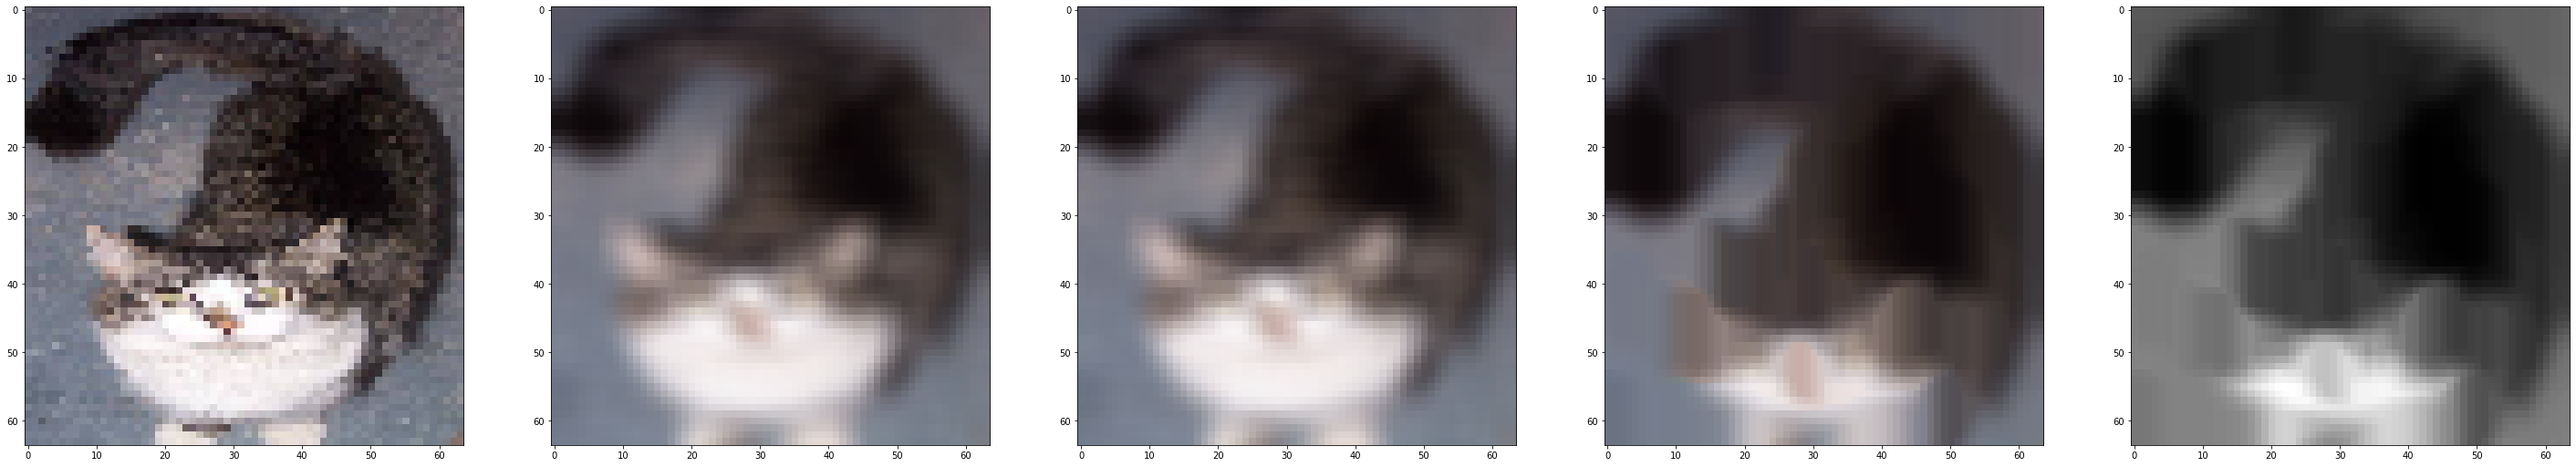

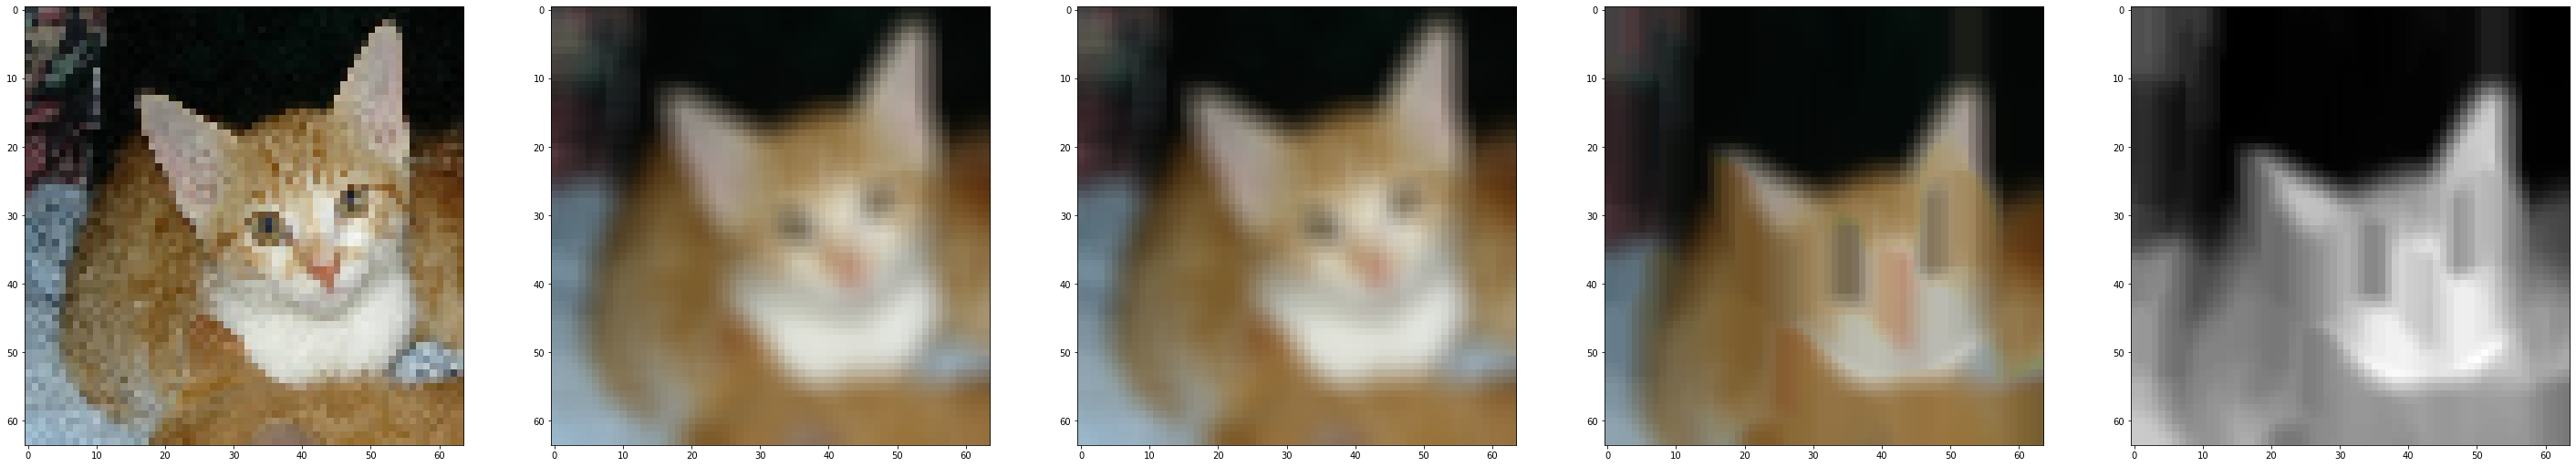

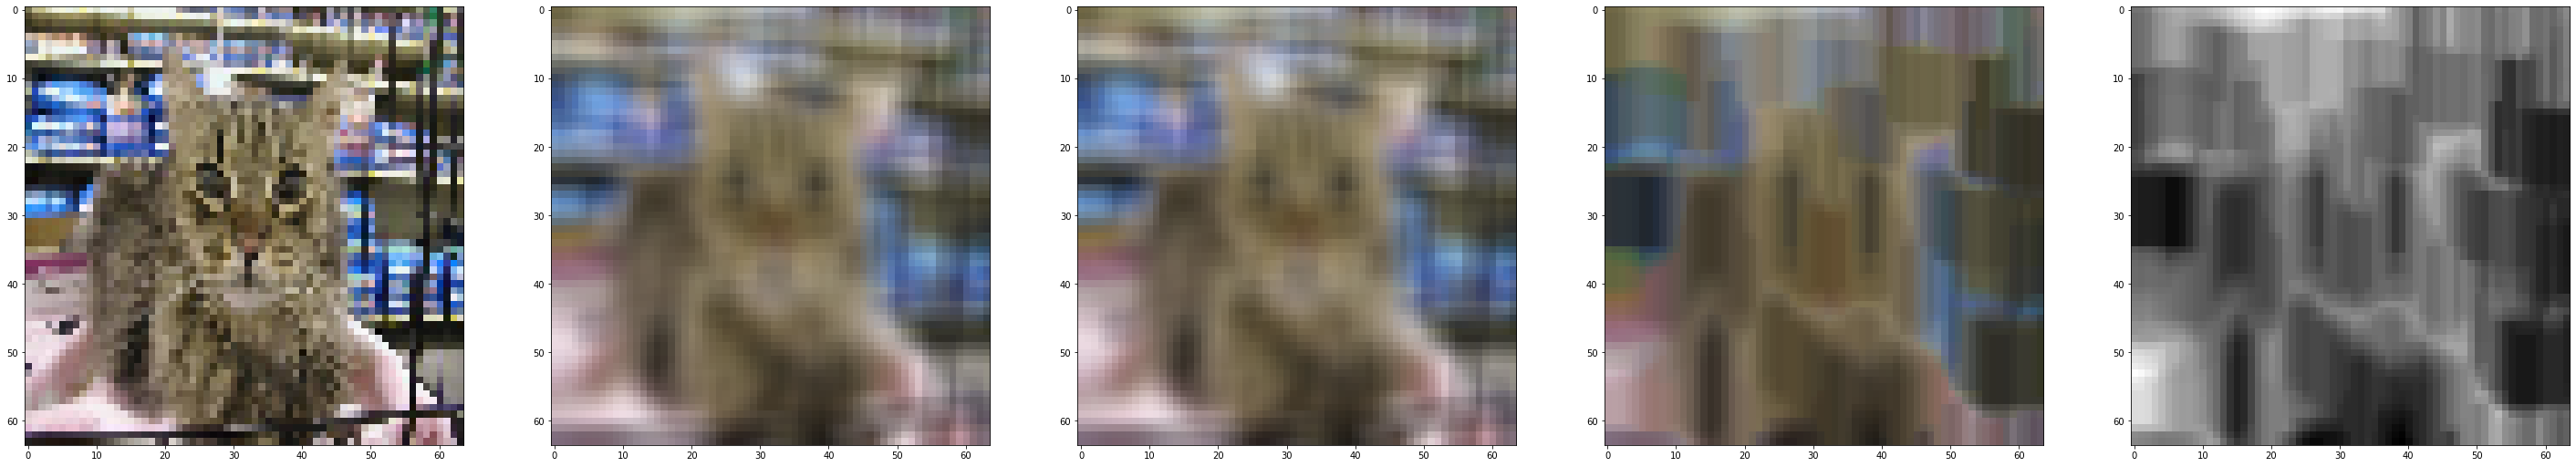

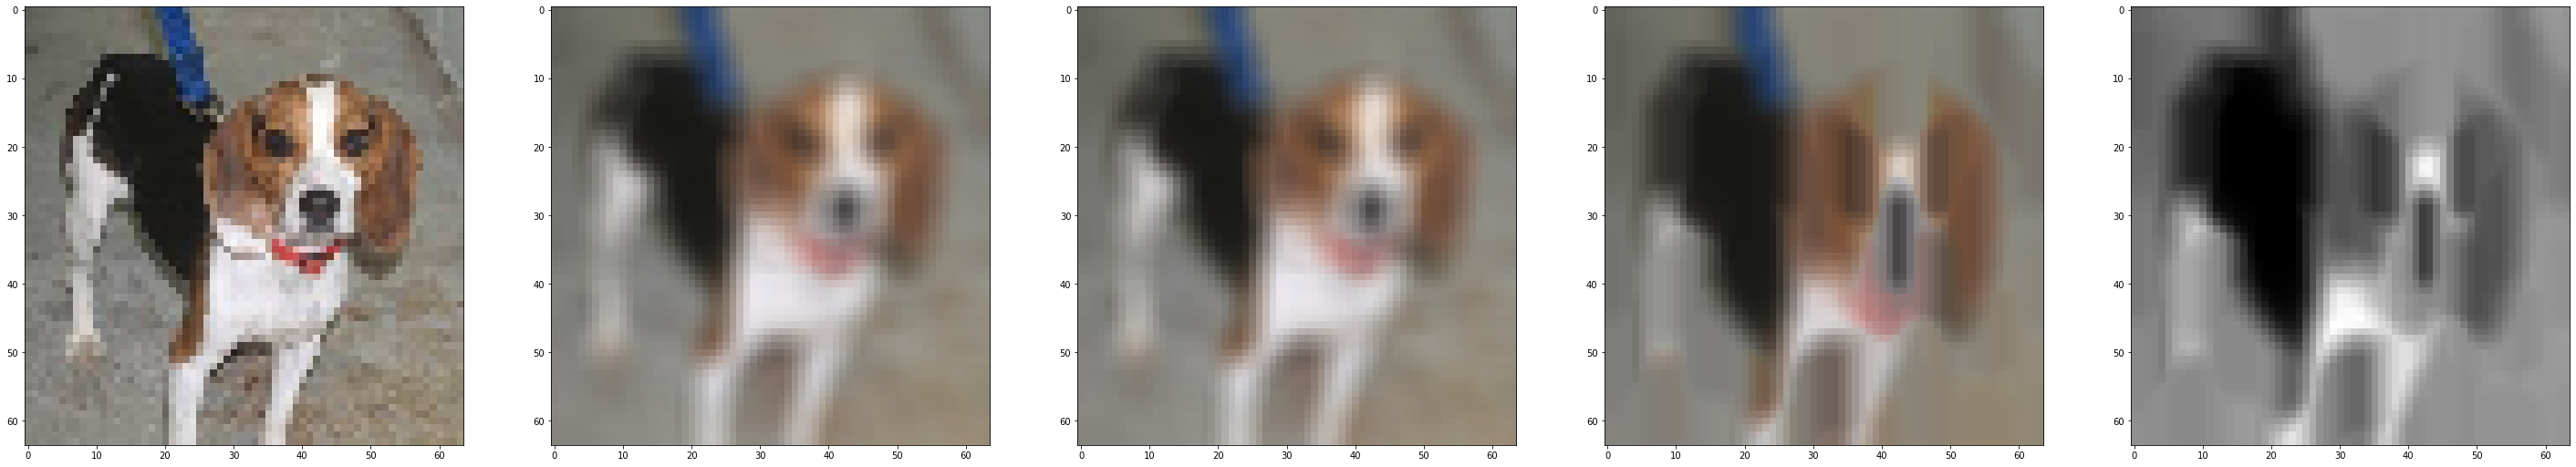

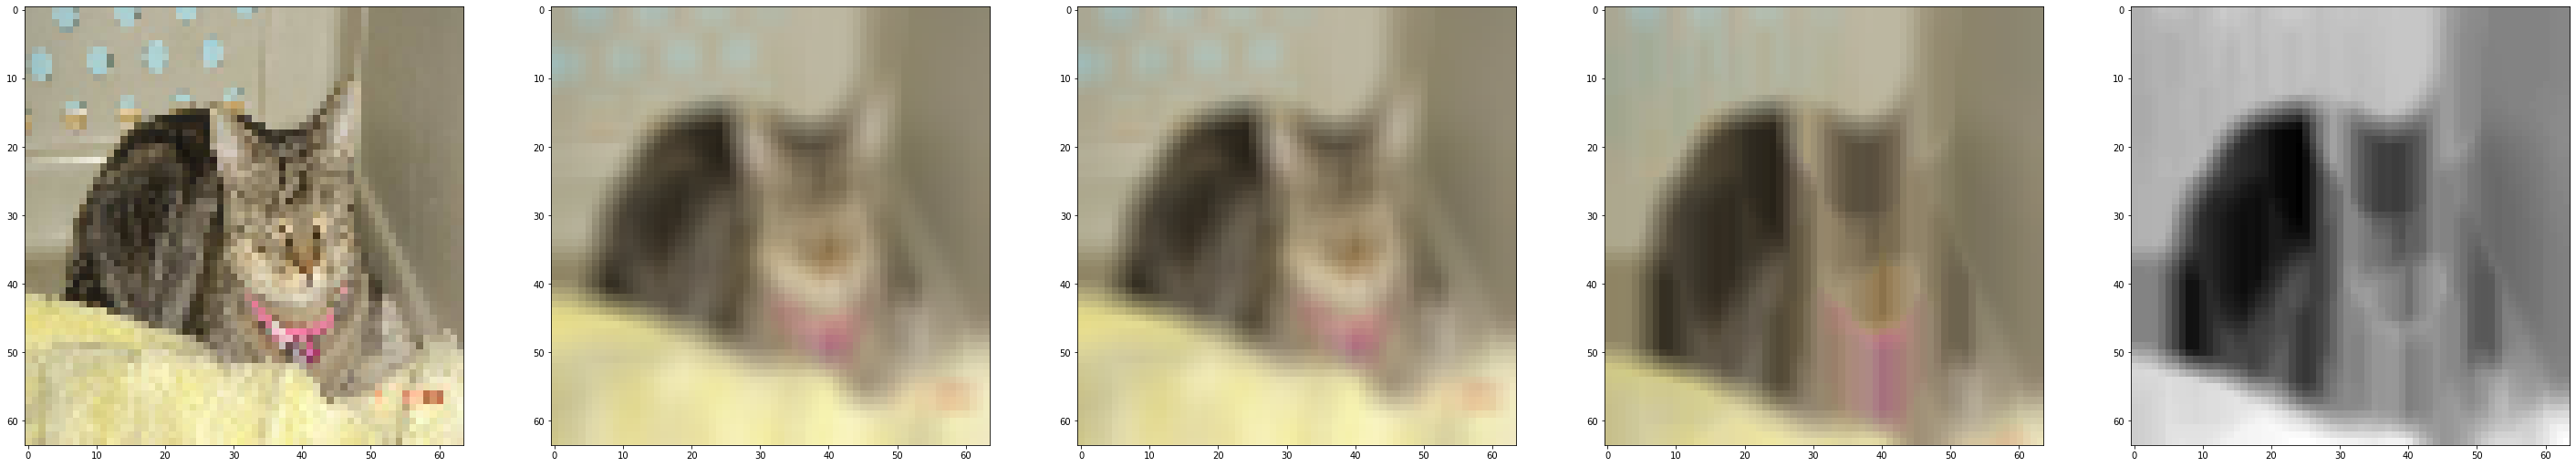

In [10]:
for i in range(5):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    fig.set_size_inches(50,10)
    ax1.imshow(cv2.cvtColor(data[i],cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(blured[i],cv2.COLOR_BGR2RGB))
    ax3.imshow(cv2.cvtColor(dilated[i],cv2.COLOR_BGR2RGB))
    ax4.imshow(cv2.cvtColor(eroded[i],cv2.COLOR_BGR2RGB))
    ax5.imshow(grayScaled[i],cmap="gray")

moving to dataframe

In [11]:
blured = None
dilated = None
eroded = None
final_data = np.array([a.flatten()/255 for a in grayScaled])
final_data.shape

(25000, 4096)

In [12]:
df = pd.DataFrame(final_data)
final_data=None
grayScaled = None
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.341176,0.341176,0.345098,0.337255,0.337255,0.333333,0.325490,0.325490,0.321569,0.317647,...,0.470588,0.474510,0.470588,0.470588,0.466667,0.466667,0.470588,0.478431,0.474510,0.478431
1,0.258824,0.254902,0.266667,0.243137,0.239216,0.196078,0.184314,0.188235,0.184314,0.188235,...,0.466667,0.466667,0.466667,0.466667,0.447059,0.431373,0.411765,0.400000,0.388235,0.376471
2,0.400000,0.403922,0.423529,0.478431,0.509804,0.533333,0.549020,0.552941,0.537255,0.537255,...,0.466667,0.447059,0.411765,0.384314,0.384314,0.454902,0.400000,0.376471,0.337255,0.356863
3,0.384314,0.388235,0.392157,0.407843,0.415686,0.423529,0.431373,0.435294,0.435294,0.439216,...,0.521569,0.525490,0.521569,0.525490,0.525490,0.529412,0.533333,0.537255,0.533333,0.529412
4,0.650980,0.650980,0.658824,0.682353,0.698039,0.694118,0.694118,0.690196,0.678431,0.666667,...,0.768627,0.772549,0.768627,0.760784,0.760784,0.784314,0.803922,0.839216,0.862745,0.882353


train/test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=randomSeed)

Removing features with low imporatance

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve
import seaborn as sns
from sklearn.model_selection import validation_curve

In [15]:
def keepImportant(percent,n_estimators):
    forest = ExtraTreesClassifier(n_estimators=n_estimators,random_state=randomSeed,n_jobs=-1,verbose=1)
    forest.fit(X_train,y_train)

    importanceDF = pd.DataFrame({"label":X_train.columns, "importances":forest.feature_importances_})
    importanceDF.sort_values(by="importances",ascending=False,inplace=True)
    features_to_keep = percent*len(forest.feature_importances_)//100

    importance = forest.feature_importances_.reshape(picSize,picSize)
    sns.heatmap(importance)
    return forest, importanceDF.head(features_to_keep)["label"]

In [16]:
#train_scoreNum, test_scoreNum = validation_curve(
#                                ExtraTreesClassifier(),
#                                X = X_train, y = y_train, 
#                                param_name = 'n_estimators', 
#                                param_range = [200,600,800,1200], 
#                                cv = 5,
#                                n_jobs=-1,
#                                verbose = 1)

In [17]:

#forest, features_to_keep = keepImportant(10,2000)


In [18]:
#X_train_new = X_train[features_to_keep]
#X_test_new = X_test[features_to_keep]

In [19]:
X_train_new = X_train
X_test_new = X_test

In [20]:
X_train_new.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
34,0.556863,0.568627,0.568627,0.572549,0.576471,0.588235,0.588235,0.584314,0.580392,0.588235,...,0.372549,0.380392,0.396078,0.423529,0.443137,0.458824,0.486275,0.525490,0.541176,0.537255
1471,0.133333,0.133333,0.133333,0.129412,0.129412,0.133333,0.137255,0.137255,0.141176,0.141176,...,0.301961,0.301961,0.305882,0.301961,0.301961,0.301961,0.301961,0.298039,0.294118,0.294118
18933,0.505882,0.509804,0.505882,0.505882,0.505882,0.509804,0.509804,0.517647,0.525490,0.533333,...,0.082353,0.090196,0.094118,0.086275,0.086275,0.074510,0.066667,0.066667,0.062745,0.058824
10641,0.211765,0.215686,0.215686,0.219608,0.215686,0.215686,0.203922,0.200000,0.203922,0.207843,...,0.309804,0.309804,0.317647,0.333333,0.333333,0.337255,0.341176,0.349020,0.352941,0.345098
16951,0.403922,0.403922,0.403922,0.403922,0.396078,0.333333,0.270588,0.200000,0.133333,0.070588,...,0.313725,0.321569,0.341176,0.360784,0.388235,0.403922,0.415686,0.415686,0.415686,0.411765


In [21]:
pca = PCA()
pca.fit(X_train_new)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


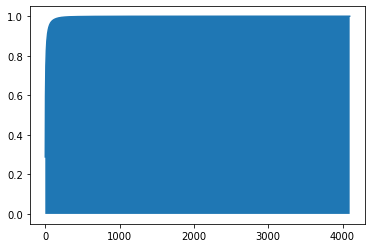

In [22]:
fig, ax = plt.subplots()
ax.plot(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul)
ax.fill_between(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul,0)

In [23]:
maxFeatures = len(exp_var_cumul[exp_var_cumul<0.95])
exp_var_cumul[maxFeatures], maxFeatures

(0.9506452282733943, 53)

In [24]:
pca = PCA(n_components=maxFeatures,random_state=randomSeed)
X_train_new = pca.fit_transform(X_train_new)
X_test_new = pca.transform(X_test_new)

In [25]:
X_train_new.shape

(20000, 53)

In [26]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [27]:
param_grid=[
    {'n_estimators':[10,20,30,200,600,1000,1200,1600,2000,2200,2600,3000],'learning_rate':[1,0.75,0.8,0.5,0.4,0.3,0.2,0.1]}
    ]

In [28]:
#model = AdaBoostClassifier(n_estimators=1000,learning_rate=0.5, random_state=randomSeed)
model = AdaBoostClassifier(random_state=randomSeed)
gridSearch = HalvingGridSearchCV(model, param_grid, cv=5,n_jobs=-1,verbose=2,random_state=randomSeed)

In [29]:

gridSearch.fit(X_train_new,y_train)
model = gridSearch.best_estimator_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 246
max_resources_: 20000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 246
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 32
n_resources: 738
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 11
n_resources: 2214
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 3
n_candidates: 4
n_resources: 6642
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 19926
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [30]:
pred = model.predict(X_test_new)

In [31]:
print("Accuracy:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 0.606
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      2506
           1       0.60      0.65      0.62      2494

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



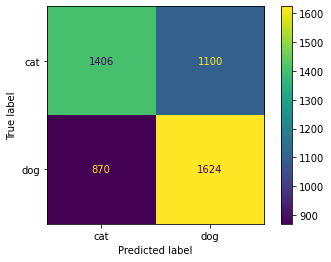

In [32]:
plot_confusion_matrix(model,X_test_new,y_test,display_labels=["cat","dog"],values_format="d")


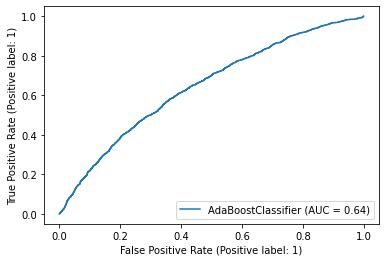

In [33]:
plot_roc_curve(model,X_test_new,y_test)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
#clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5,random_state=randomSeed)
clf = GradientBoostingClassifier(random_state=randomSeed)

In [36]:
gridSearch = HalvingGridSearchCV(clf, param_grid, cv=5,n_jobs=-1,verbose=2,random_state=randomSeed)

In [37]:
gridSearch.fit(X_train_new,y_train)
clf = gridSearch.best_estimator_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 246
max_resources_: 20000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 246
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 32
n_resources: 738
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 11
n_resources: 2214
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 3
n_candidates: 4
n_resources: 6642
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 19926
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [38]:
pred2 = clf.predict(X_test_new)

In [39]:
print("Accuracy:",accuracy_score(y_test,pred2))
print(classification_report(y_test,pred2))

Accuracy: 0.6262
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      2506
           1       0.61      0.67      0.64      2494

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000



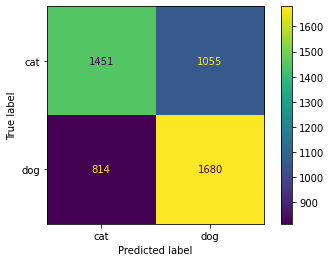

In [40]:
plot_confusion_matrix(clf,X_test_new,y_test,display_labels=["cat","dog"],values_format="d")


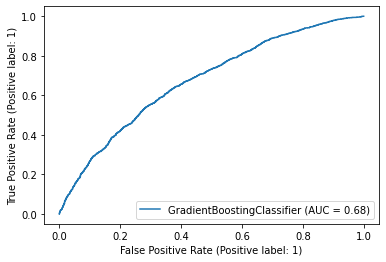

In [41]:
plot_roc_curve(clf,X_test_new,y_test)

In [42]:
from sklearn.ensemble import VotingClassifier

In [43]:
voting = VotingClassifier(estimators=[('gBoost',clf),('adaBoost',model)],n_jobs=-1,verbose=1)
voting.fit(X_train_new,y_train)

VotingClassifier(estimators=[('gBoost',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         n_estimators=200,
                                                         random_state=36)),
                             ('adaBoost',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 n_estimators=1000,
                                                 random_state=36))],
                 n_jobs=-1, verbose=1)

In [44]:
pred3 = voting.predict(X_test_new)

In [45]:
print("Accuracy:",accuracy_score(y_test,pred3))
print(classification_report(y_test,pred3))

Accuracy: 0.618
              precision    recall  f1-score   support

           0       0.61      0.66      0.63      2506
           1       0.63      0.58      0.60      2494

    accuracy                           0.62      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.62      0.62      0.62      5000



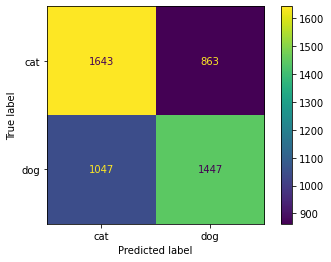

In [46]:
plot_confusion_matrix(voting,X_test_new,y_test,display_labels=["cat","dog"],values_format="d")


In [47]:
plot_roc_curve(voting,X_test_new,y_test)

ValueError: response method decision_function or predict_proba is not defined in VotingClassifier